Welcome to the second topic in your favorite course. In this notebook we will discuss methods of enhancing our regression model.



1.   Detecting and removing outliers. <br>
outliers can result in a significant drop in the performace of our model. Unless the outlier is your grade in an exam (in a good way) it is necessary to cancel them out when relevant.



In [ ]:
#it is a good practice to import everything u might need from the beginning not
#to waste time and memory footprint is not of our concern atm.
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

For this notebook, we will be using the Uber dataset. As this dataset is relatively big, it will take time to download and upload. A solution for that is to upload it to your drive and connect it here. Do not worry, I have done this for you already. All you need to do is to run the cell below and follow the steps to connect. (Shared it with your gmail account)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


you can see your drive as a folder now in the folders panel. Now lets read the dataset from there. I have shared a folder called ML4S with you. If this cell generated an error you just need to go to your drive -> shared with me -> right click on the ML4S folder -> create a shortcut in my drive.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ML4S/Datasets/uber.csv')
df

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5
...,...,...,...,...,...,...,...,...,...
199995,42598914,2012-10-28 10:49:00.00000053,3.0,2012-10-28 10:49:00 UTC,-73.987042,40.739367,-73.986525,40.740297,1
199996,16382965,2014-03-14 01:09:00.0000008,7.5,2014-03-14 01:09:00 UTC,-73.984722,40.736837,-74.006672,40.739620,1
199997,27804658,2009-06-29 00:42:00.00000078,30.9,2009-06-29 00:42:00 UTC,-73.986017,40.756487,-73.858957,40.692588,2
199998,20259894,2015-05-20 14:56:25.0000004,14.5,2015-05-20 14:56:25 UTC,-73.997124,40.725452,-73.983215,40.695415,1


cleaning the dataset as usual.

In [ ]:
df = df.drop(columns = ['Unnamed: 0', 'key', 'pickup_datetime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        200000 non-null  float64
 1   pickup_longitude   200000 non-null  float64
 2   pickup_latitude    200000 non-null  float64
 3   dropoff_longitude  199999 non-null  float64
 4   dropoff_latitude   199999 non-null  float64
 5   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 9.2 MB


all seems good except that there is a null row in dropoff_longitude and latitude column. lets drop that row.

In [1]:
df = df.dropna(subset = ['dropoff_longitude'])
df.info()

NameError: ignored

This was just to illustrate how to deal with empty rows. Overall geotags are not needed either so it will be dropped. :D

In [ ]:
# df = df.drop(columns = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'])

#more fancy way to do it
##another reason why python is very cool

for i in df.columns: #df.columns returns columns names. this loop is simply saying if the column (i) name ends with 'tude' then drop it :D
  if i.endswith('tude'):
    df = df.drop(columns = [i])

df

,fare_amount,passenger_count
0,7.5,1
1,7.7,1
2,12.9,1
3,5.3,3
4,16.0,5
...,...,...
199995,3.0,1
199996,7.5,1
199997,30.9,2
199998,14.5,1


now that the data is clean lets see how can we identify outliers.

1.   Generate statistical information



In [ ]:
df.describe()

,fare_amount,passenger_count
count,199999.000000,199999.000000
mean,11.359892,1.684543
std,9.901760,1.385995
min,-52.000000,0.000000
25%,6.000000,1.000000
50%,8.500000,1.000000
75%,12.500000,2.000000
max,499.000000,208.000000


looking at fare_amount column, we can notice that the maximum is 499. However, the mean is around 11. This clearly shows that something is wrong. Similar observation can be obtained from passenger_count column. Both columns thereby contain outliers.

lets dig deeper and see if it is one outlier or many outliers. There are many ways to do so through visualizations. We will have a look at three of them.

a) Histograms

[Text(0.5, 1.0, 'Histogram of fare amount')]

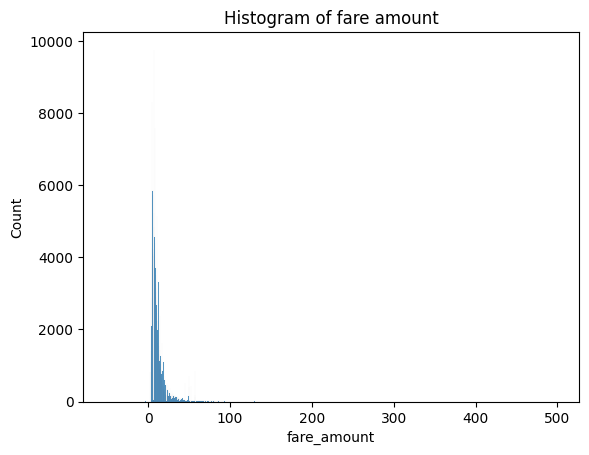

In [ ]:
sns.histplot(df['fare_amount']).set(title='Histogram of fare amount') #this is how u can add a title btw :D

looks zoomed out. we can fix this.

(1.0, 6000.0)

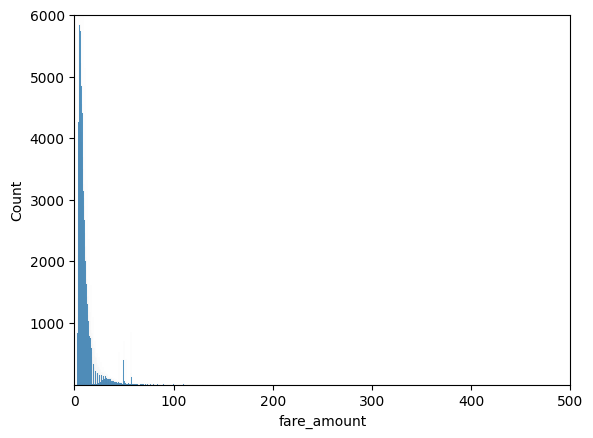

In [ ]:
import matplotlib.pyplot as plt #pyplot is a useful library to modify visualizations so we will use it here (it is a headache but resourceful)
# plot distplot
fig, ax = plt.subplots()
sns.histplot(df['fare_amount'], ax = ax)

# This will change the limits of the x and y axis
ax.set_xlim(0, 500)
ax.set_ylim(1, 6000)

we can clearly see the issue here. The histogram does not follow a normal distribution (bell shape) but rather skewed to the left.

Practice Problem 1) plot the histogram of passenger count.

(1.0, 6000.0)

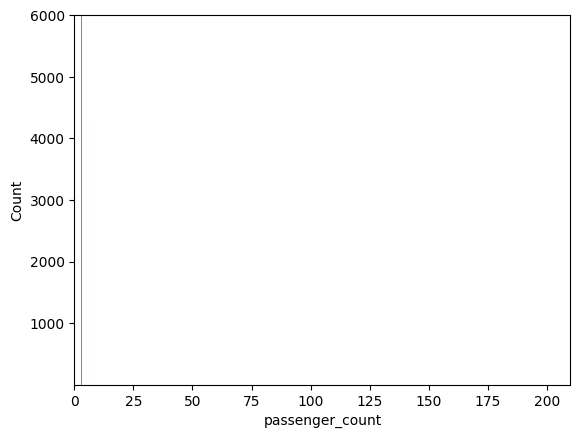

In [ ]:
#@title Solution
fig, ax = plt.subplots()
sns.histplot(df['passenger_count'], ax = ax)

# This will change the limits of the x and y axis
ax.set_xlim(0, 210)
ax.set_ylim(1, 6000)
#crisis

b) Box plots

<Axes: >

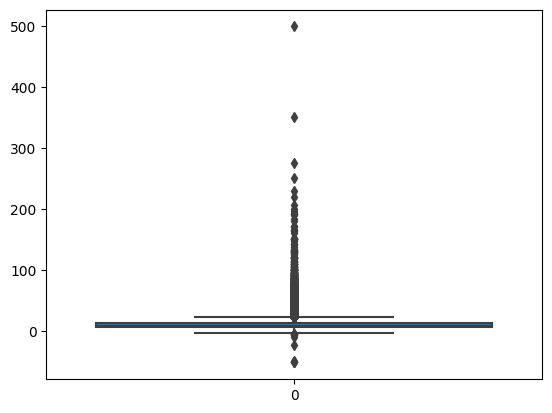

In [ ]:
sns.boxplot(df['fare_amount'])

As we can see, most of the points are distributed between 0 and 200. However, many points are so far from the mean (the thick line in the middle). The two small lines are the first and third quantiles.

2- Dealing with outliers. <br>

outiers issue can be fixed by either dropping them or capping them. Personally (and given that we have 200k records) dropping them is a better option to avoid the hassle.

But..how can we find and drop them? <br> for that we use the z-score statistical method. In short, an outlier has a z-score above 3. Identify these rows and drop them out.

In [ ]:
from scipy import stats #scipy is a data science specialized library built on top of numpy
df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)] #keep each row where the column satisfies the condition z < 3
#.all attribute applies the function on every column
#axis is coming from .shape [row (0), column (1)]. Here we direct any to move between columns

As you can see the number of rows decreased.

Now we have dropped all outliers, lets verify if everything makes sense.

In [ ]:
df.describe()

,fare_amount,passenger_count
count,190416.000000,190416.000000
mean,10.154765,1.588055
std,6.413920,1.153219
min,-10.900000,0.000000
25%,6.000000,1.000000
50%,8.100000,1.000000
75%,12.100000,2.000000
max,41.040000,5.000000


looking good! :D

Practice Problem) <br>

Use the weather dataset you worked on last time (available on the drive) for this problem. <br>

1. Drop description.

2. The dataset contains some outliers. Can you identify which columns contain outliers using the mean rule?  

3. Use a visualization method to investigate the columns you suspect. <br> (Hint: you are expected to find two columns containing outliers.)

4. Rain column does not contain outliers. Nonetheless, it seems to have some. What makes Rain column special?

5. drop all outliers and have a look at your dataframe.

6. implement linear regression from 001 again using the same metrics. you can copy and paste.

7. Drop out the boolean variable Rain and note if it is useful or not.

8. Compare both models. Did you notice an improvement?

9. R-squared is a good metric. However, it is known to be biased. Another metric is called Adjusted R-squared. Compare both.

10. plot the regression plot of the new model. Any interesting observation?

11. Looking at the regression plot. Is a linear model the best choice? if not, what other mathematical formula seems to be more fitting?

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

df = pd.read_csv('/content/weather.csv')

In [ ]:
# Drop the Description column
df = df.drop(columns = ['Description'])

In [ ]:
# Using the mean rule to identify outliers
df.describe()

,Temperature_c,Humidity,Wind_Speed_kmh,Wind_Bearing_degrees,Visibility_km,Pressure_millibars,Rain
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,11.857208,0.735272,10.813565,185.979700,10.372964,1004.896421,0.891200
std,9.512244,0.195498,6.972569,107.469909,4.178680,109.617120,0.311404
min,-21.822222,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.655556,0.600000,5.747700,112.000000,8.287475,1011.890000,1.000000
50%,11.561111,0.780000,9.933700,179.000000,10.046400,1016.500000,1.000000
75%,18.822222,0.900000,14.103600,290.000000,14.876400,1021.110000,1.000000
max,38.838889,1.000000,53.242700,359.000000,16.100000,1045.380000,1.000000


We notice that Humidity and Pressure_millibars colums have outliers. (not too sure if its humidity or Wind_Bearing_degrees or another one, but i thought of humidity 1st)
- Humidity has a max of 1 and a min of 0, but the mean is 0.735, meaning that we might have outliers that caused it to become skewed like this.
- Similarly, with Pressure_millibars the max is 1045 and the min is 0 but the mean is 1004 which is very off.


[Text(0.5, 1.0, 'Histogram of Humidity')]

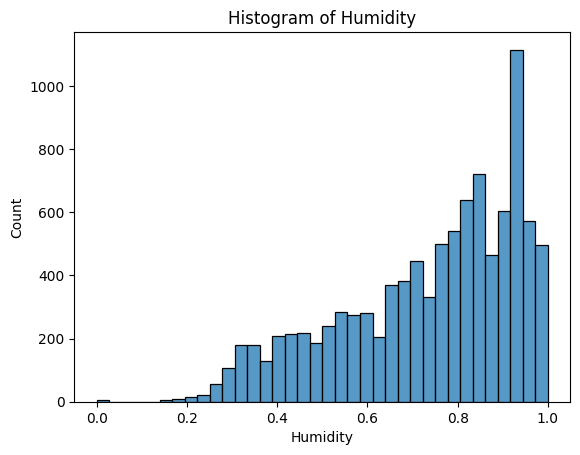

In [ ]:
sns.histplot(df['Humidity']).set(title='Histogram of Humidity')

As can be seen from above, the Humidity histogram isn't really giving a bell shape, the data is skewed to the right.

[Text(0.5, 1.0, 'Histogram of Pressure_millibars')]

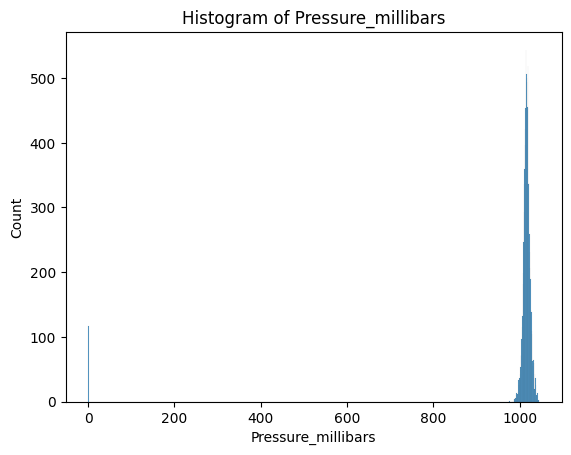

In [ ]:
sns.histplot(df['Pressure_millibars']).set(title='Histogram of Pressure_millibars')

As can be seen from above, the Pressure_millibars histogram isn't really giving a bell shape, almost all our data points are clustered around the max value.

- **Rain column does not contain outliers. Nonetheless, it seems to have some. What makes Rain column special?**

    Rain column represents True/False values which have been binary encoded into 0s and 1s. Rain can be considered a categorical variable which has two categories (rain and no rain) hence we can't really say we have outliers since every datapoint has a meaning and is significant.

    I read something about class imbalance, so here maybe we can say that we have a class imbalance where we have a lot more 1s(rain) than zeros(no rain), other than saying we have outliers.


In [ ]:
# Drop outliers
df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

In [ ]:
df.describe()

,Temperature_c,Humidity,Wind_Speed_kmh,Wind_Bearing_degrees,Visibility_km,Pressure_millibars,Rain
count,9540.000000,9540.000000,9540.000000,9540.000000,9540.000000,9540.000000,9540.000000
mean,12.051956,0.736456,10.226914,184.481447,10.406397,1016.960193,0.894444
std,9.483132,0.195491,6.009683,107.498174,4.193923,7.303589,0.307284
min,-16.111111,0.160000,0.000000,0.000000,0.000000,995.120000,0.000000
25%,4.838889,0.600000,5.538400,110.000000,8.335775,1012.300000,1.000000
50%,12.063889,0.790000,9.660000,178.000000,10.046400,1016.700000,1.000000
75%,18.890278,0.900000,13.829900,288.000000,14.908600,1021.220000,1.000000
max,37.894444,1.000000,28.239400,359.000000,16.100000,1038.760000,1.000000


In [ ]:
# Split the data into predictors (X) and target (y)
X = df.drop(columns = ['Temperature_c']) # Drop all columns except Temperature_c
y = df['Temperature_c']

from sklearn.preprocessing import MinMaxScaler
Scaler = MinMaxScaler()
X = Scaler.fit_transform(X)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=47)

from sklearn.linear_model import LinearRegression
model = LinearRegression()
regressor = model.fit(X_train,y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print("R-squared score:", r2)

R-squared score: 0.6354481832322745


In [ ]:
# Drop the Rain column
df = df.drop(columns = ['Rain'])

In [ ]:
# Split the data into predictors (X) and target (y)
X = df.drop(columns = ['Temperature_c']) # Drop all columns except Temperature_c
y = df['Temperature_c']

from sklearn.preprocessing import MinMaxScaler
Scaler = MinMaxScaler()
X = Scaler.fit_transform(X)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=47)

from sklearn.linear_model import LinearRegression
model = LinearRegression()
regressor = model.fit(X_train,y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print("R-squared score:", r2)

# Calculate Adjusted R-squared
n = len(y_test) # The number of observations
k = X_train.shape[1] # The number of predictor variables
adjusted_r_squared = 1 - (1 - r2) * (n - 1) / (n - k - 1)
print("Adjusted R-squared:", adjusted_r_squared)

R-squared score: 0.5359868076889317
Adjusted R-squared: 0.5350320480339708


- **Drop out the Boolean variable Rain and note if it is useful or not.**

  Dropping the Rain variable wasn't useful, in fact, it reduced the R-squared value from 63.54% to 53.59% which is not what we want. We want to get the R-squared value closer to 1.
  

- **Compare both models. Did you notice an improvement?**

  The model in 001 had a R-squared score of nearly 0.5813 and in this model it is 0.6354. We notice that there was a slight improvement in the model after removing the outliers, but it still needs more improvement as 0.6354 is still not that close to 1.

- **R-squared is a good metric. However, it is known to be biased. Another metric is called Adjusted R-squared. Compare both.**

  The Adjusted R-squared value is calculated using the R-squared value, number of observations, number of predictor variables.
  As seen above
  
  R-squared score: 0.5359868076889317

  Adjusted R-squared: 0.5350320480339708

  We don't really notice a difference in both these values. This model has 5 predictor variables, and we found the R-squared and Adjusted R-squared for the same model so it is expected that they'll be similar.

  If we want to compare two models that have a different number of predictor variables for example then we'll have to use the Adjusted R-squared since it accounts for the number of predictor variables and will actually help us form a conclusion on the models.


<Axes: xlabel='Temperature_c'>

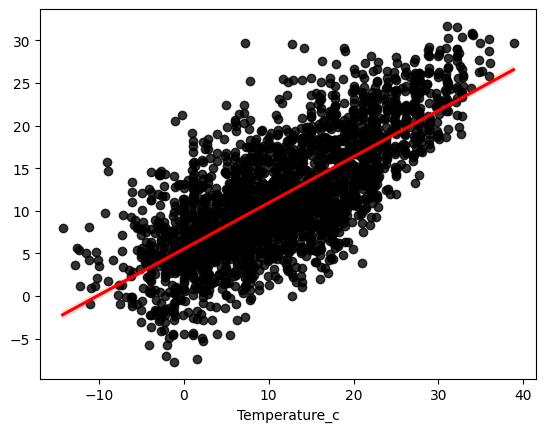

In [ ]:
sns.regplot(x= y_test, y = y_pred, scatter_kws={"color": "black"}, line_kws={"color": "red"})

- **plot the regression plot of the new model. Any interesting observation?**

  If we look at the previous model in 001 we notice that data had sort of like a discontinuity, or we can say it was kind of separated into two parts or two clusters, though it doesn't look that significant maybe. In the regression plot here we notice that the data are more evenly and homogeneously spread out.

- **Looking at the regression plot. Is a linear model the best choice? if not, what other mathematical formula seems to be more fitting?**
  
  It appears that a linear model is the best choice since we don't really see that much of a distinct shape that can be considered polynomial, exponential, logarithmic, etc.
